In [44]:
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.datasets import load_boston
from sklearn.datasets import make_regression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import scale
import matplotlib.pyplot as plt
from sklearn import set_config 


#calculate wbgt with R script /research/calculate_wbgt.R using the data for each statio and year from:
#https://www.meteoswiss.admin.ch/home/climate/swiss-climate-in-detail/climate-scenarios-indoor-climate.html
wbgt = "".join(["/Users/szelie/OneDrive - ETH Zurich/data/heat/ch2018_buildings/ch2018_raumklima_wbgt/wbgt.csv"])
wbgt = pd.read_csv(wbgt)


In [45]:
min_T = wbgt[['time.mm', 'time.dd', 'tre200h0','station']].groupby(['time.mm','time.dd', 'station']).min().reset_index()
max_T = wbgt[['time.mm', 'time.dd', 'tre200h0','station']].groupby(['time.mm','time.dd', 'station']).max().reset_index()
min_T = min_T.rename(columns={'tre200h0':'tasmin'})
max_T = max_T.rename(columns={'tre200h0':'tasmax'})
wbgt = pd.merge(wbgt,min_T, on=['time.mm','time.dd', 'station'])
wbgt = pd.merge(wbgt,max_T, on=['time.mm','time.dd', 'station'])
wbgt =wbgt[wbgt['tasmax']>23]
wbgt = wbgt.dropna()
wbgt = wbgt[(wbgt['time.hh']>8)&(wbgt['time.hh']<18)]
X = wbgt[['time.hh','tasmin','tasmax']] 
Y = wbgt['wbgt_sun']

from sklearn.model_selection import train_test_split
from sklearn import linear_model
# splitting the data
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2, random_state = 42)


In [334]:
wbgt

,time.yy,time.mm,time.dd,time.hh,tre200h0,ure200h0,fkl010h0,fkl010h1,dkl010h0,skycover,...,dewp,lat,lon,station,strinside,wbgt_sun,wbgt_shadow,wbgt_inside,tasmin,tasmax
3272,2035,5,17,8,20.8,37.1,1.4,3.3,132,0.0,...,8.22,46.8,8.2,1,0,20.503778,15.353736,15.996165,11.6,25.8
3273,2035,5,17,9,22.8,31.8,1.6,3.6,120,0.0,...,9.16,46.8,8.2,1,0,21.457297,16.821625,17.455028,11.6,25.8
3274,2035,5,17,10,24.5,24.9,2.5,7.8,162,0.0,...,9.48,46.8,8.2,1,0,21.850860,17.918391,18.537346,11.6,25.8
3275,2035,5,17,11,25.2,22.4,4.4,7.7,158,0.0,...,9.68,46.8,8.2,1,0,21.673177,18.408123,18.999840,11.6,25.8
3276,2035,5,17,12,25.5,23.7,3.8,8.4,172,0.0,...,10.24,46.8,8.2,1,0,21.504372,18.746797,19.340492,11.6,25.8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
891517,2060,10,9,13,27.3,42.8,6.1,9.9,238,85.0,...,15.86,46.8,8.2,102,0,23.258780,21.774579,22.239557,19.2,27.3
891518,2060,10,9,14,26.0,51.1,5.0,9.6,256,83.0,...,16.22,46.8,8.2,102,0,21.240134,21.240134,21.668217,19.2,27.3
891519,2060,10,9,15,25.9,51.0,3.2,6.6,229,81.0,...,16.10,46.8,8.2,102,0,21.854718,21.118045,21.568141,19.2,27.3
891520,2060,10,9,16,24.9,56.2,2.3,6.2,252,79.0,...,16.14,46.8,8.2,102,0,22.206856,20.592975,21.037217,19.2,27.3


In [46]:
rfr_sun = RandomForestRegressor(n_estimators=10, max_depth=6)
rfr_sun.fit(x_train, y_train)

score = rfr_sun.score(x_train, y_train)
print("R-squared:", score) 

R-squared: 0.6999525995785089


In [47]:
import statsmodels.api as sm
import numpy as np
from sklearn.metrics import mean_squared_error


y_prediction_rfr = rfr_sun.predict(x_test) 

np.sqrt(mean_squared_error(y_test,y_prediction_rfr))


1.8145035579153919

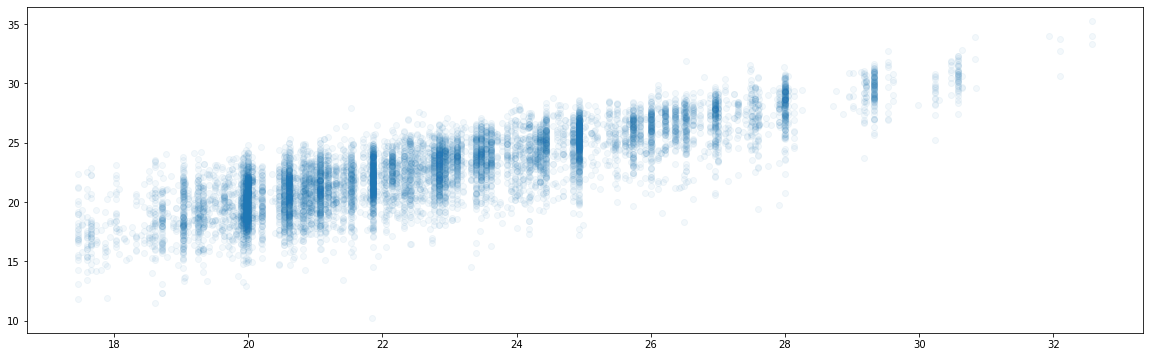

In [48]:
import statsmodels.api as sm

model = sm.OLS(Y, X).fit()
y_prediction = model.predict(x_test) 
import numpy as np
from sklearn.metrics import mean_squared_error

fig, ax = plt.subplots(figsize=(20,6))
#ax.scatter(y_prediction, y_test)
ax.scatter(y_prediction_rfr, y_test,alpha=0.05)

In [64]:
import joblib
joblib.dump(rfr_sun, "/Users/szelie/python_projects/heat_mortality_productivity_impacts/input_data/regressions/random_forest_wbgt_sun.joblib")


['/Users/szelie/python_projects/heat_mortality_productivity_impacts/input_data/regressions/random_forest_wbgt_sun.joblib']

In [50]:
wbgt = "".join(["/Users/szelie/OneDrive - ETH Zurich/data/heat/ch2018_buildings/ch2018_raumklima_wbgt/wbgt.csv"])
wbgt = pd.read_csv(wbgt)

min_T = wbgt[['time.mm', 'time.dd', 'tre200h0','station']].groupby(['time.mm','time.dd', 'station']).min().reset_index()
max_T = wbgt[['time.mm', 'time.dd', 'tre200h0','station']].groupby(['time.mm','time.dd', 'station']).max().reset_index()
min_T = min_T.rename(columns={'tre200h0':'tasmin'})
max_T = max_T.rename(columns={'tre200h0':'tasmax'})
wbgt = pd.merge(wbgt,min_T, on=['time.mm','time.dd', 'station'])
wbgt = pd.merge(wbgt,max_T, on=['time.mm','time.dd', 'station'])
wbgt =wbgt[wbgt['tasmax']>23]
wbgt = wbgt.dropna()
wbgt = wbgt[(wbgt['time.hh']>8)&(wbgt['time.hh']<18)]


X = wbgt[['time.hh','tasmin','tasmax']] 
Y = wbgt['wbgt_shadow']

from sklearn.model_selection import train_test_split
from sklearn import linear_model
# splitting the data
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2, random_state = 42)

# with sklearn
regr = linear_model.LinearRegression()
regr.fit(x_train, y_train)

print('Intercept: \n', regr.intercept_)
print('Coefficients: \n', regr.coef_)

y_prediction_linear = regr.predict(x_test)


Intercept: 
 -2.22290377266609
Coefficients: 
 [0.1507666  0.21653997 0.64074929]


In [51]:
import statsmodels.api as sm
import numpy as np
from sklearn.metrics import mean_squared_error

rfr_shadow = RandomForestRegressor(n_estimators=10,max_depth=8)
rfr_shadow.fit(x_train, y_train)

y_prediction_rfr = rfr_shadow.predict(x_test) 

np.sqrt(mean_squared_error(y_test,y_prediction_rfr))

1.0704528967117959

In [53]:
import joblib
joblib.dump(rfr_shadow, "/Users/szelie/python_projects/heat_mortality_productivity_impacts/input_data/regressions/random_forest_wbgt_shadow.joblib")

['/Users/szelie/python_projects/heat_mortality_productivity_impacts/input_data/regressions/random_forest_wbgt_shadow.joblib']

In [54]:
wbgt_inside = pd.read_csv("/Users/szelie/python_projects/heat_mortality_productivity_impacts/input_data/wbgt/operating_temperature_2060.csv")

In [55]:
wbgt_inside = wbgt_inside[['time.dd', 'date','time.mm', 'time.hh', 'wbgt_inside','wbgt_sun','wbgt_shadow', 'tre200h0', 'operating_temperature']]


In [56]:
min_T = wbgt_inside[['time.mm', 'time.dd', 'tre200h0']].groupby(['time.mm','time.dd']).min().reset_index()
max_T = wbgt_inside[['time.mm', 'time.dd', 'tre200h0']].groupby(['time.mm','time.dd']).max().reset_index()

In [57]:
min_T = min_T.rename(columns={'tre200h0':'tasmin'})
max_T = max_T.rename(columns={'tre200h0':'tasmax'})

In [58]:
wbgt_inside = pd.merge(wbgt_inside,min_T, on=['time.mm','time.dd'])
wbgt_inside = pd.merge(wbgt_inside,max_T, on=['time.mm','time.dd'])

In [60]:
from sklearn import linear_model

wbgt_inside = wbgt_inside[wbgt_inside['tasmax']>23]
wbgt_inside = wbgt_inside.dropna()
wbgt_inside = wbgt_inside[(wbgt_inside['time.hh']>8)&(wbgt_inside['time.hh']<18)]
X = wbgt_inside[['time.hh','tasmin','tasmax']] # here we have 2 variables for multiple regression. If you just want to use one variable for simple linear regression, then use X = df['Interest_Rate'] for example.Alternatively, you may add additional variables within the brackets
Y = wbgt_inside['wbgt_inside']

from sklearn.model_selection import train_test_split
# splitting the data
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2, random_state = 42)

# with sklearn
rfr_inside = RandomForestRegressor(n_estimators=10, max_depth=8)
rfr_inside.fit(x_train, y_train)

score = rfr_inside.score(x_train, y_train)
print("R-squared:", score) 



R-squared: 0.9860451467635523


In [61]:
y_prediction = rfr_inside.predict(x_test) 
np.sqrt(mean_squared_error(y_test,y_prediction))



0.40333789364891304

In [65]:
array = np.ones([1,3])
array[0][0] = 14
array[0][1] = 16
array[0][2] = 30
print(rfr_inside.predict(array))

print(rfr_shadow.predict(array))

print(rfr_sun.predict(array))


[21.06016739]
[23.38262765]
[25.72989185]


/Users/szelie/miniconda3/envs/climada_env/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/Users/szelie/miniconda3/envs/climada_env/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/Users/szelie/miniconda3/envs/climada_env/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


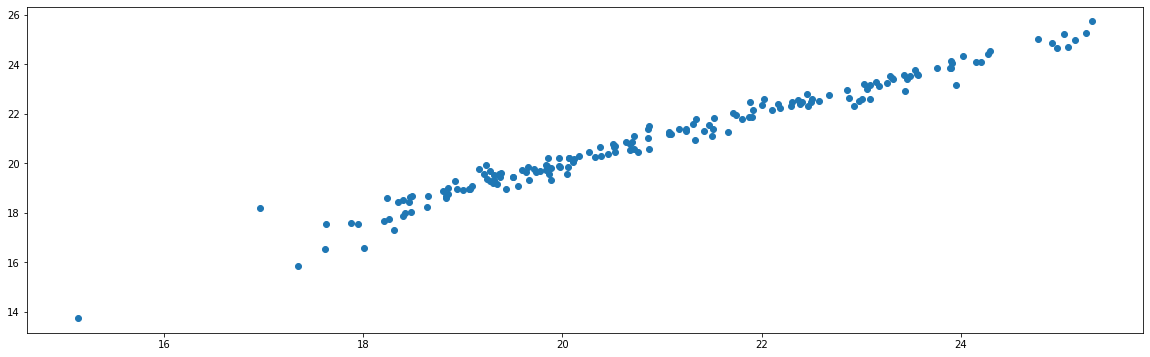

In [529]:
fig, ax = plt.subplots(figsize=(20,6))
ax.scatter(y_prediction, y_test)


In [63]:
import joblib
joblib.dump(rfr_inside, "/Users/szelie/python_projects/heat_mortality_productivity_impacts/input_data/regressions/random_forest_wbgt_inside.joblib")

['/Users/szelie/python_projects/heat_mortality_productivity_impacts/input_data/regressions/random_forest_wbgt_inside.joblib']

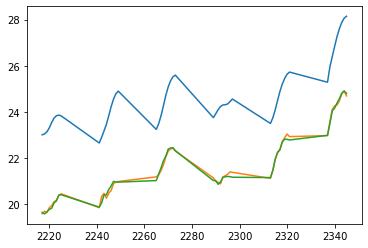

In [391]:
fig,ax =plt.subplots()

wbgt_7d = wbgt_inside[(wbgt_inside['time.mm']==8)&(wbgt_inside['time.dd']<7)]
ax.plot(wbgt_7d.index, wbgt_7d.operating_temperature)
ax.plot(wbgt_7d.index, wbgt_7d.wbgt_inside)
wbgt_inside_est = rfr_inside.predict(wbgt_7d[['time.hh','tasmin','tasmax']])
ax.plot(wbgt_7d.index, wbgt_inside_est)



In [557]:
wbgt

,time.yy,time.mm,time.dd,time.hh,tre200h0,ure200h0,fkl010h0,fkl010h1,dkl010h0,skycover,...,dewp,lat,lon,station,strinside,wbgt_sun,wbgt_shadow,wbgt_inside,tasmin,tasmax
3273,2035,5,17,9,22.8,31.8,1.6,3.6,120,0.0,...,9.16,46.8,8.2,1,0,21.457297,16.821625,17.455028,11.6,25.8
3274,2035,5,17,10,24.5,24.9,2.5,7.8,162,0.0,...,9.48,46.8,8.2,1,0,21.850860,17.918391,18.537346,11.6,25.8
3275,2035,5,17,11,25.2,22.4,4.4,7.7,158,0.0,...,9.68,46.8,8.2,1,0,21.673177,18.408123,18.999840,11.6,25.8
3276,2035,5,17,12,25.5,23.7,3.8,8.4,172,0.0,...,10.24,46.8,8.2,1,0,21.504372,18.746797,19.340492,11.6,25.8
3277,2035,5,17,13,25.8,26.6,3.9,8.1,150,12.0,...,11.12,46.8,8.2,1,0,22.413900,19.206661,19.783684,11.6,25.8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
891517,2060,10,9,13,27.3,42.8,6.1,9.9,238,85.0,...,15.86,46.8,8.2,102,0,23.258780,21.774579,22.239557,19.2,27.3
891518,2060,10,9,14,26.0,51.1,5.0,9.6,256,83.0,...,16.22,46.8,8.2,102,0,21.240134,21.240134,21.668217,19.2,27.3
891519,2060,10,9,15,25.9,51.0,3.2,6.6,229,81.0,...,16.10,46.8,8.2,102,0,21.854718,21.118045,21.568141,19.2,27.3
891520,2060,10,9,16,24.9,56.2,2.3,6.2,252,79.0,...,16.14,46.8,8.2,102,0,22.206856,20.592975,21.037217,19.2,27.3


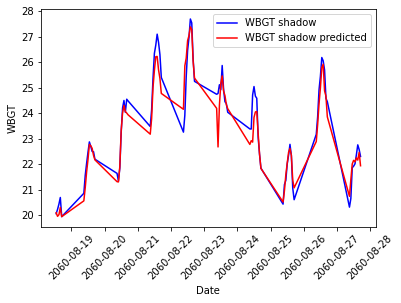

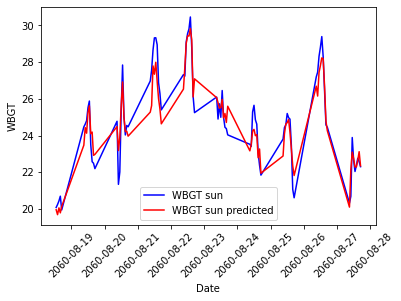

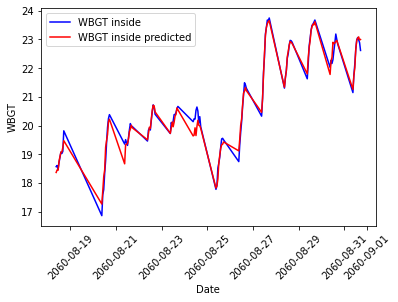

In [40]:
#### 

wbgt_7d = wbgt[(wbgt['time.mm']==8)]
wbgt_7d = wbgt_7d[wbgt_7d['station']==17][130:]

wbgt_sun_est = rfr_sun.predict(wbgt_7d[['time.hh','tasmin','tasmax']])
wbgt_shadow_est = rfr_shadow.predict(wbgt_7d[['time.hh','tasmin','tasmax']])



fig,ax =plt.subplots()

ax.plot(pd.to_datetime(wbgt_7d.date), wbgt_7d.wbgt_shadow, color='blue', label='WBGT shadow')
ax.plot(pd.to_datetime(wbgt_7d.date), wbgt_shadow_est, color='red', label='WBGT shadow predicted')


ax.tick_params(axis='x', rotation=45)
ax.set_ylabel('WBGT')
ax.set_xlabel('Date')
ax.legend()
plt.savefig('../figures/wbgt_shadow.pdf',bbox_inches='tight')   




fig,ax =plt.subplots()
ax.plot(pd.to_datetime(wbgt_7d.date), wbgt_7d.wbgt_sun, color='blue', label='WBGT sun')
ax.plot(pd.to_datetime(wbgt_7d.date), wbgt_sun_est, color='red', label='WBGT sun predicted')
ax.tick_params(axis='x', rotation=45)
ax.set_ylabel('WBGT')
ax.set_xlabel('Date')
ax.legend()
plt.savefig('../figures/wbgt_sun.pdf',bbox_inches='tight')   





wbgt_7d_inside = wbgt_inside[(wbgt_inside['time.mm']==8)&(wbgt_inside['time.dd']>15)]
#wbgt_7d = wbgt_inside[wbgt_inside['station']==17]

wbgt_inside_est = rfr_inside.predict(wbgt_7d_inside[['time.hh','tasmin','tasmax']])



fig,ax =plt.subplots()
ax.plot(pd.to_datetime(wbgt_7d_inside.date), wbgt_7d_inside.wbgt_inside, color='blue', label='WBGT inside')
ax.plot(pd.to_datetime(wbgt_7d_inside.date), wbgt_inside_est, color='red', label='WBGT inside predicted')
ax.tick_params(axis='x', rotation=45)
ax.set_ylabel('WBGT')
ax.set_xlabel('Date')
ax.legend()
plt.savefig('../figures/wbgt_inside.pdf',bbox_inches='tight')   





In [544]:
pd.to_datetime(wbgt_7d_inside.date)

1473   2060-01-07 09:00:00
1474   2060-01-07 10:00:00
1475   2060-01-07 11:00:00
1476   2060-01-07 12:00:00
1477   2060-01-07 13:00:00
               ...        
2197   2060-07-31 13:00:00
2198   2060-07-31 14:00:00
2199   2060-07-31 15:00:00
2200   2060-07-31 16:00:00
2201   2060-07-31 17:00:00
Name: date, Length: 270, dtype: datetime64[ns]

In [545]:
pd.to_datetime(wbgt_7d.date)

145257   2060-08-01 09:00:00
145258   2060-08-01 10:00:00
145259   2060-08-01 11:00:00
145260   2060-08-01 12:00:00
145261   2060-08-01 13:00:00
                 ...        
145885   2060-08-27 13:00:00
145886   2060-08-27 14:00:00
145887   2060-08-27 15:00:00
145888   2060-08-27 16:00:00
145889   2060-08-27 17:00:00
Name: date, Length: 216, dtype: datetime64[ns]